In [1]:
import prior
dataset = prior.load_dataset("procthor-10k")

house = dataset["train"][20]

AE: https://api.github.com/repos/allenai/procthor-10k/commits?sha=main
[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9223.36it/s]


In [3]:
print(house)
rooms = []
for room in house["rooms"]:
    room_poly = [(corner["x"], corner["z"]) for corner in room["floorPolygon"]]
    #print(room["roomType"] + " # " + str(room["floorPolygon"]))
    #print(room["roomType"] + " ?? " + str(room_poly))
    rooms.append((room["roomType"], room_poly))

print(rooms)

for room in rooms:
    print(room[1])

{'doors': [{'assetId': 'Doorway_Double_7', 'id': 'door|4|5', 'openable': True, 'openness': 1, 'room0': 'room|5', 'room1': 'room|4', 'wall0': 'wall|5|8.35|0.00|8.35|6.68', 'wall1': 'wall|4|8.35|0.00|8.35|6.68', 'holePolygon': [{'x': 4.353640555830781, 'y': 0, 'z': 0}, {'x': 6.301061391325776, 'y': 2.0971285314299166, 'z': 0}], 'assetPosition': {'x': 5.32681868454266, 'y': 1.0462727337144315, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|6|7', 'openable': True, 'openness': 1, 'room0': 'room|7', 'room1': 'room|6', 'wall0': 'wall|7|6.68|10.02|6.68|11.69', 'wall1': 'wall|6|6.68|10.02|6.68|11.69', 'holePolygon': [{'x': 0.5769642321808005, 'y': 0, 'z': 0}, {'x': 1.6145027606231834, 'y': 2.0979503514245152, 'z': 0}], 'assetPosition': {'x': 1.0944141168562438, 'y': 1.0459483740851283, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|4|6', 'openable': True, 'openness': 1, 'room0': 'room|4', 'room1': 'room|6', 'wall0': 'wall|4|8.35|6.68|13.36|6.68', 'wall1': 'wall|6|8.35|6.68|13.36|6.68', 'holePol

In [78]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

def is_point_inside_room(point_to_test, room_polygon):
    (x, y, z) = point_to_test
    point = Point(x, z)
    polygon = Polygon(room_polygon)
    return polygon.contains(point)

def what_room_is_point_in(rooms, point):
    for room in rooms:
        if is_point_inside_room(point, room[1]):
            return room[0]
    return "NONE"

True


In [61]:
import glob
import pickle
from room_type import RoomType

def find_observed_point_by_pose(pose, room_points):
    #(pos, rot) = pose # ((10.75, 1.57599937915802, 1.0), (30.000003814697266, 0.0, 0))
    result = None
    for rp in room_points:
        if rp['point_pose'] == pose:
            result = rp
            return result
    return result

def process_scene_files(llm_type):
    #pkl_mistral = "pkl_mistral/diff*.pkl"
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"
    #print(glob.glob(pkl_gemma)) 

    accuracies_per_room_llm = []
    accuracies_per_room_svc = []
    accuracies_per_room_cvm = []
    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes
    #scene_files = ["experiment_data/pkl_" + llm_type + "/scene_descr_train_56.pkl"]

    # per all rooms
    all_rooms_llm_good = 0
    all_rooms_svc_good = 0
    all_rooms_cvm_good = 0
    all_rooms_elapsed_time_llm = 0
    all_rooms_elapsed_time_svc = 0
    all_rooms_elapsed_time_cvm = 0
    all_rooms_total_points = 0
    min_points = 10000000000
    max_points = -1

    min_objs_pp = 10000000000
    max_objs_pp = -1

    min_elapsed_time_llm = 10000000000
    min_elapsed_time_svc = 10000000000
    min_elapsed_time_cvm = 10000000000
    max_elapsed_time_llm = -1
    max_elapsed_time_svc = -1
    max_elapsed_time_cvm = -1

    max_t_labels = set()
    min_t_labels = set()

    total_total_points = 0
    storages_and_offices = 0
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #print(scene_f.split("/"))
        f_name = scene_f.split("/")[2]
        cor_llm_pkl_path = "experiment_data/pkl_LLAMA/" + f_name # corresponding LLM pkl path
        llm_f = open(cor_llm_pkl_path,'rb')
        llm_scene = pickle.load(llm_f)

        room_points = scene.get_all_points()
        llm_room_points = llm_scene.get_all_points()

#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }

        # per room
        llm_good = 0
        svc_good = 0
        cvm_good = 0
        elapsed_time_llm = 0
        elapsed_time_svc = 0
        elapsed_time_cvm = 0
        total_points = 0

        print(str(len(room_points)) + " " + str(len(llm_room_points)) + " " + cor_llm_pkl_path + " " + scene_f)
        
        for rp in room_points:
            #rp = room_points[i]
            #llm_rp = llm_room_points[i]
            llm_rp = find_observed_point_by_pose(rp['point_pose'], llm_room_points)
            if llm_rp is None:
                llm_rp_room_type = RoomType.NOT_CLASSIFIED
            else:
                llm_rp_room_type = llm_rp["room_type_llm"]
            # if we want to skip points that were classified as STORAGE or OFFICE (not categories that we have in ground truth)
            #if (rp["room_type_svc"] == RoomType.NOT_CLASSIFIED or rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    continue
            
            # if we want to skip points that SVC didn't classify (usually when there are only common objects)
            #if (rp["room_type_svc"] == RoomType.NOT_CLASSIFIED):
            #    continue

            ## if we want to re-classify OFFICE and STORAGE as BEDROOM
            if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE or rp["room_type_cvm"] == RoomType.NOT_KNOWN):
                print("MISCLASS: " + rp["room_type_cvm"].name + " " + llm_rp_room_type.name + " " + rp["room_type_gt"].name + " " + str(rp["visible_object_names"]) + " # " + rp['cvm_text'] + " # " + rp["front_view_at_this_point"])
                storages_and_offices += 1
                rp["room_type_cvm"] = RoomType.BEDROOM

            # if we want to re-classify OFFICE and STORAGE as LIVING ROOM
            #if (rp["room_type_cvm"] == RoomType.OFFICE or rp["room_type_cvm"] == RoomType.STORAGE):
            #    rp["room_type_cvm"] = RoomType.LIVING_ROOM
            
            total_points += 1
            total_total_points += 1
            all_rooms_total_points += 1
            
            # counting correct classifications per method
            if rp["room_type_gt"] == rp["room_type_llm"]:
                llm_good += 1
                all_rooms_llm_good += 1
            #if rp["room_type_llm"] != rp["room_type_svc"] and rp["room_type_llm"] != rp["room_type_gt"]:
                #print(rp["room_type_llm"].name + " # " + rp["room_type_svc"].name + " # " + rp["room_type_gt"].name + " # " + str(rp["elapsed_time_llm"]) + " # " + str(rp["elapsed_time_svc"]))
                #print(rp["visible_object_names"])
            
            if rp["room_type_gt"] == rp["room_type_svc"]:
                svc_good += 1
                all_rooms_svc_good += 1

            if rp["room_type_gt"] == rp["room_type_cvm"]:
                cvm_good += 1
                all_rooms_cvm_good += 1

            # collecting inference time
            elapsed_time_llm += rp["elapsed_time_llm"]
            elapsed_time_svc += rp["elapsed_time_svc"]
            elapsed_time_cvm += rp["elapsed_time_cvm"]
            all_rooms_elapsed_time_llm += rp["elapsed_time_llm"]
            all_rooms_elapsed_time_svc += rp["elapsed_time_svc"]
            all_rooms_elapsed_time_cvm += rp["elapsed_time_cvm"]

            # collecting min and max visible objects per point
            if min_objs_pp > len(rp["visible_object_names"]):
                min_objs_pp = len(rp["visible_object_names"])
    
            if max_objs_pp < len(rp["visible_object_names"]):
                max_objs_pp = len(rp["visible_object_names"])

            # collecting min and max inference time
            if min_elapsed_time_llm > rp["elapsed_time_llm"]:
                min_elapsed_time_llm = rp["elapsed_time_llm"]
                min_t_labels = rp["visible_object_names"]
            if max_elapsed_time_llm < rp["elapsed_time_llm"]:
                max_elapsed_time_llm = rp["elapsed_time_llm"]
                max_t_labels = rp["visible_object_names"]
            if min_elapsed_time_svc > rp["elapsed_time_svc"]:
                min_elapsed_time_svc = rp["elapsed_time_svc"]
            if max_elapsed_time_svc < rp["elapsed_time_svc"]:
                max_elapsed_time_svc = rp["elapsed_time_svc"]
            if min_elapsed_time_cvm > rp["elapsed_time_cvm"]:
                min_elapsed_time_cvm = rp["elapsed_time_cvm"]
            if max_elapsed_time_cvm < rp["elapsed_time_cvm"]:
                max_elapsed_time_cvm = rp["elapsed_time_cvm"]
        
        #print("llm_good = " + str(llm_good / total_points) + " # " + "svc_good = " + str(svc_good / total_points) + " # llm_time_avg = " + str(elapsed_time_llm / total_points) + " # svc_time_avg = " + str(elapsed_time_svc / total_points))

        # collecting min and max points per habitat
        if min_points > total_points:
            min_points = total_points

        if max_points < total_points:
            max_points = total_points

        # calculating mean accuracy per method
        accuracies_per_room_llm.append(llm_good / total_points)
        accuracies_per_room_svc.append(svc_good / total_points)
        accuracies_per_room_cvm.append(cvm_good / total_points)

        llm_f.close()
        f.close()
        #print("\n")
    print("min_points = " + str(min_points) + " # " + " max_points = " + str(max_points) + " # total_total_points=" + str(total_total_points))
    print("min_objs_pp = " + str(min_objs_pp) + " # " + " max_objs_pp = " + str(max_objs_pp))
    print("min_elapsed_time_llm = " + str(min_elapsed_time_llm) + " # " + "max_elapsed_time_llm = " + str(max_elapsed_time_llm))
    print("min_elapsed_time_svc = " + str(min_elapsed_time_svc) + " # " + "max_elapsed_time_svc = " + str(max_elapsed_time_svc))
    print("min_elapsed_time_cvm = " + str(min_elapsed_time_cvm) + " # " + "max_elapsed_time_cvm = " + str(max_elapsed_time_cvm))
    
    print("min_t_labels = " + str(min_t_labels) + " # " + "max_t_labels = " + str(max_t_labels))
    print("storages_and_offices = " + str(storages_and_offices) + " # " + "max_t_labels = " + str(max_t_labels))
    
    #print("mean llm time: " + str(all_rooms_elapsed_time_llm / all_rooms_total_points) + " mean svc time: " + str(all_rooms_elapsed_time_svc / all_rooms_total_points))

    #print("min_points = " + str(min_points) + " # " + "max_points = " + str(max_points))

    # returning mean calculated accuracies and mean inference times
    return (accuracies_per_room_llm, accuracies_per_room_svc, accuracies_per_room_cvm, (all_rooms_elapsed_time_llm / all_rooms_total_points), (all_rooms_elapsed_time_svc / all_rooms_total_points), (all_rooms_elapsed_time_cvm / all_rooms_total_points), storages_and_offices)
#scene_descr_llm_fname = "pkl_mistral/scene_descriptions_llm.pkl"
#scene_descr_svc_fname = "pkl_mistral/scene_descriptions_svc.pkl"
#if (os.path.isfile(scene_descr_llm_fname) and os.path.isfile(scene_descr_svc_fname)):
#    file_llm = open(scene_descr_llm_fname,'rb')
#    file_svc = open(scene_descr_svc_fname,'rb')
#    scene_descriptions_llm = pickle.load(file_llm)

#process_scene_files("mistral")
#process_scene_files("gemma")
#process_scene_files("CHAMELEON")
#process_scene_files("CHAMELEON_full_prompt")
process_scene_files("MOONDREAM_full_prompt")
#process_scene_files("MOONDREAM_one_word")

161 149 experiment_data/pkl_LLAMA/scene_descr_train_10.pkl experiment_data/pkl_MOONDREAM_full_prompt/scene_descr_train_10.pkl
MISCLASS: NOT_KNOWN LIVING_ROOM KITCHEN {'Wall', 'HousePlant'} # The image depicts a small, empty room with a plant in a pot, a desk, and a painting on the wall. The room appears to be a simple, minimalist space with a focus on the plant and the desk. The presence of a painting on the wall suggests that the room might be a living or working space, but the lack of furniture and other objects in the room indicates that it is not a fully furnished or decorated area. The room's simplicity and minimalistic design might be appealing to those who prefer a clutter-free environment or who are looking for a space to focus on a single activity, such as working or studying. # scene_pics/train_10/2.png
MISCLASS: OFFICE BEDROOM LIVING_ROOM {'Doorframe', 'Wall', 'FloorLamp'} # The image shows a small, empty room with a yellow floor and a black counter. There is a desk in the r

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.5093167701863354,
  0.6277372262773723,
  0.5119047619047619,
  0.6025641025641025,
  0.575,
  0.40425531914893614,
  0.544,
  0.5510204081632653,
  0.5756097560975609,
  0.5585585585585585,
  0.5555555555555556,
  0.5254237288135594,
  0.41304347826086957,
  0.5,
  0.6063348416289592,
  0.4367816091954023,
  0.6534653465346535,
  0.5103092783505154,
  0.5210526315789473,
  0.696969696969697,
  0.3761194029850746,
  0.6424581005586593,
  0.5424836601307189,
  0.49673202614379086,
  0.6301369863013698],
 [0.5900621118012422,
  0.583941605839416,
  0.5992063492063492,
  0.5897435897435898,
  0.625,
  0.44680851063829785,
  0.528,
  0.5265306122448979,
  0.5073170731707317,
  0.5945945945945946,
  0.5661375661375662,
  0.5480225988700564,
  0.45652173913043476,
  0.4482758620689655,
  0.5701357466063348,
  0.528

161 149 experiment_data/pkl_LLAMA/scene_descr_train_10.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_10.pkl
137 127 experiment_data/pkl_LLAMA/scene_descr_train_18.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_18.pkl
252 195 experiment_data/pkl_LLAMA/scene_descr_train_1.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_1.pkl
78 64 experiment_data/pkl_LLAMA/scene_descr_train_7.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_7.pkl
160 134 experiment_data/pkl_LLAMA/scene_descr_train_15.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_15.pkl
94 81 experiment_data/pkl_LLAMA/scene_descr_train_43.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_43.pkl
125 118 experiment_data/pkl_LLAMA/scene_descr_train_35.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_35.pkl
245 195 experiment_data/pkl_LLAMA/scene_descr_train_25.pkl experiment_data/pkl_CHAMELEON/scene_descr_train_25.pkl
205 166 experiment_data/pkl_LLAMA/scene_descr_train_13.pkl experiment_data/pkl_CHAMELEON/scene_d

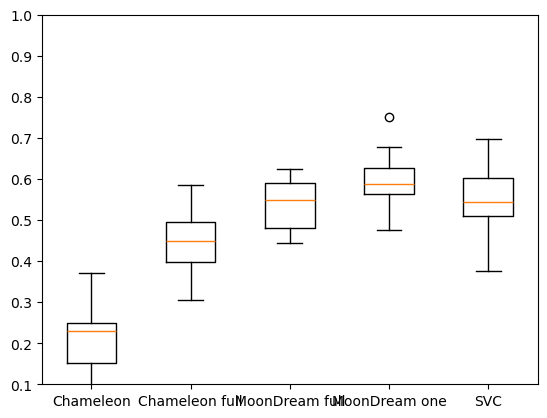

cvm_mean_time_cham = 41.452013970095365
cvm_mean_time_cham_fp = 53.33633196800421
cvm_mean_time_md_fp = 23.509972103689528
cvm_mean_time_md_ow = 11.989318196371952
svc_mean_time = 0.0005123038869257921


In [59]:
import matplotlib.pyplot as plt
import numpy as np

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testRoomClassifierAccuracy(llm_type):
    (llm_accuracies, svc_accuracies, cvm_accuracies, llm_mean_time, svc_mean_time, cvm_mean_time) = process_scene_files(llm_type)
    # should be 3 volumes -- one for LLM and one for SVC and one for CVM for accuracies compared to ground truth.
    number_of_dataset_volumes = 3

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(llm_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = llm_accuracies
    dataset_test_results[1] = svc_accuracies
    dataset_test_results[2] = cvm_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    #ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
    #if (model_type == ModelType.HYBRID_AT_12):
    #    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
    #elif (model_type == ModelType.HYBRID_AT_18):
    #    ax.set_title("Scannet - Hybridized with AI2-THOR data")
    ax.boxplot(dataset_test_results)
    plt.ylim(0.3, 1.0)
    plt.show()

#testRoomClassifierAccuracy("gemma")
#testRoomClassifierAccuracy("mistral")
#testRoomClassifierAccuracy("LLAMA")

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testAllRoomClassifiersAccuracy():
    (llm_accuracies, svc_accuracies, cvm_accuracies_cham, llm_mean_time, svc_mean_time, cvm_mean_time_cham, storages_and_offices_cham) = process_scene_files("CHAMELEON")
    (llm_accuracies, svc_accuracies, cvm_accuracies_cham_fp, llm_mean_time, svc_mean_time, cvm_mean_time_cham_fp, storages_and_offices_cham_fp) = process_scene_files("CHAMELEON_full_prompt")
    (llm_accuracies, svc_accuracies, cvm_accuracies_md_fp, llm_mean_time, svc_mean_time, cvm_mean_time_md_fp, storages_and_offices_md_fp) = process_scene_files("MOONDREAM_full_prompt")
    (llm_accuracies, svc_accuracies, cvm_accuracies_md_ow, llm_mean_time, svc_mean_time, cvm_mean_time_md_ow, storages_and_offices_md_ow) = process_scene_files("MOONDREAM_one_word")
    # should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
    number_of_dataset_volumes = 5

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(svc_accuracies)
    print(str(len(svc_accuracies)) + " " + str(len(cvm_accuracies_cham)) + " " + str(len(cvm_accuracies_cham_fp)) + " " + str(len(cvm_accuracies_md_fp)) + " " + str(len(cvm_accuracies_md_ow)))
    print(str(storages_and_offices_cham) + " " + str(storages_and_offices_cham))

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = cvm_accuracies_cham
    dataset_test_results[1] = cvm_accuracies_cham_fp
    dataset_test_results[2] = cvm_accuracies_md_fp
    dataset_test_results[3] = cvm_accuracies_md_ow
    dataset_test_results[4] = svc_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    #ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
    #if (model_type == ModelType.HYBRID_AT_12):
    #    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
    #elif (model_type == ModelType.HYBRID_AT_18):
    #    ax.set_title("Scannet - Hybridized with AI2-THOR data")
    ax.boxplot(dataset_test_results, labels=['Chameleon', 'Chameleon full', 'MoonDream full', 'MoonDream one', 'SVC'])
    ax.axes.get_xaxis().set_visible(True)
    plt.ylim(0.1, 1.0)
    #plt.xticks([1, 2, 3], ['mon', 'tue', 'wed'])
    plt.show()

    print("cvm_mean_time_cham = " + str(cvm_mean_time_cham))
    print("cvm_mean_time_cham_fp = " + str(cvm_mean_time_cham_fp))
    print("cvm_mean_time_md_fp = " + str(cvm_mean_time_md_fp))
    print("cvm_mean_time_md_ow = " + str(cvm_mean_time_md_ow))
    print("svc_mean_time = " + str(svc_mean_time))

testAllRoomClassifiersAccuracy()

ValueError: X must have 2 or fewer dimensions

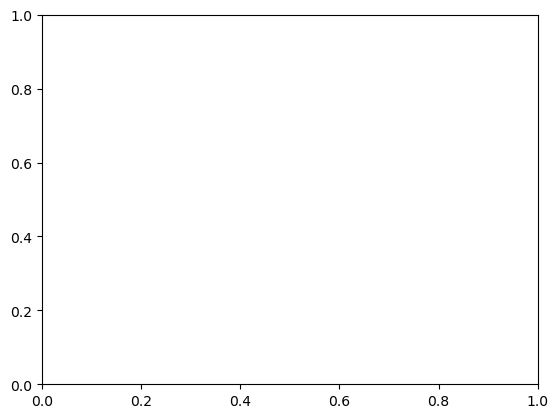

In [49]:
data = [[np.random.rand(100)] for i in range(3)]
plt.boxplot(data)
#plt.xticks([1, 2, 3], ['mon', 'tue', 'wed'])

In [36]:
from ae_gemma_llm import GemmaLLMControl
from room_type import RoomType
from scene_description import ClassifierType

glc = GemmaLLMControl()

def getAllVisibleObjectNamesInThisRoom(scene, classifier_type, rt):
  points = scene.get_all_points_of_room_type(classifier_type, rt)
  ret_set = set()
  for p in points:
      ret_set = ret_set.union(p["visible_object_names"])

  return ret_set

def process_scene_files(llm_type):
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #obj_names = scene.getAllVisibleObjectNamesInThisRoom(ClassifierType.LLM, RoomType.KITCHEN)
        #points = scene.get_all_points_of_room_type(ClassifierType.LLM, RoomType.KITCHEN)
        print(getAllVisibleObjectNamesInThisRoom(scene, ClassifierType.LLM, RoomType.KITCHEN))
        
#        for p in points:
            #print(p)
#            print(p["visible_object_names"])
        #print("KITCHEN: " + str(obj_names))
        #glc.construct_object_selector_question_ranking("fresh bottle of beer", )
        
#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }
        f.close()

process_scene_files("llama")

{'ButterKnife', 'Wall', 'CreditCard', 'Bread', 'Vase', 'Pen', 'Toaster', 'Drawer', 'Stool', 'Shelf', 'ShelvingUnit', 'SaltShaker', 'Floor', 'GarbageCan', 'Chair', 'CoffeeMachine', 'Window', 'CounterTop', 'Fridge', 'DishSponge', 'SideTable', 'HousePlant', 'Doorway', 'Bowl', 'DeskLamp', 'Mug', 'Pot', 'DiningTable'}
{'Wall', 'Box', 'Faucet', 'Sink', 'Doorway', 'BasketBall', 'Painting', 'SinkBasin', 'GarbageCan'}
{'Wall', 'Bread', 'Fork', 'Vase', 'Potato', 'Tomato', 'SoapBottle', 'Safe', 'Doorframe', 'SaltShaker', 'Floor', 'Cart', 'Window', 'CounterTop', 'Fridge', 'Pencil', 'Doorway', 'Painting', 'HousePlant', 'DiningTable', 'Laptop'}
{'Candle', 'GarbageBag', 'Vase', 'Egg', 'CoffeeMachine', 'Window', 'CellPhone', 'Faucet', 'WineBottle', 'Painting', 'HousePlant', 'DiningTable', 'Cup', 'SprayBottle', 'Wall', 'Fork', 'Tomato', 'RemoteControl', 'Sink', 'KeyChain', 'Floor', 'Bottle', 'GarbageCan', 'Cart', 'Chair', 'CounterTop', 'Pan', 'Fridge', 'Doorway', 'Apple', 'Book', 'Bowl', 'SinkBasin', '

In [4]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.MISTRAL_6b)

lc.construct_object_selector_question_ranking("fresh bottle of beer", {'SprayBottle', 'Shelf', 'Wall', 'BaseballBat', 'Bowl', 'HousePlant', 'Doorway', 'Plate', 'Vase', 'Potato', 'Toaster', 'ArmChair', 'Painting', 'Window', 'Apple', 'CounterTop', 'Chair', 'Pencil', 'DiningTable', 'Cart', 'Floor', 'GarbageBag', 'Fridge', 'ShelvingUnit', 'Drawer', 'WineBottle'})
lc.get_object_selector_answer()

3
 LLM :mistral:7b-instruct-v0.2-q6_K
3
 Based on the given context, a fresh bottle of beer is most likely to be found near a Fridge. The reason for this is that refrigerators are commonly used to store beer, as the cool temperature helps preserve the carbonation and freshness of the beer. Therefore, a fresh bottle of beer would typically be found in or nearby a fridge.

Ranking of objects from most likely to least likely to be near a fresh bottle of beer:
1. Fridge
2. Shelving Unit (for storing beer bottles)
3. CounterTop (where one might open and pour the beer)
4. Table (such as a dining table or coffee table, where one might drink the beer)
5. Floor (if the bottle was accidentally dropped)
6. Cart (used to transport heavy items such as cases of beer)
7. Wall (as in a beer tap wall or beer fridge built into a wall)
8. SprayBottle (unrelated)
9. Vase (unrelated)
10. HousePlant (unrelated)
11. Shelf (while beer can be stored on shelves, it is more likely to be found in a refrigerator o

In [32]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.GEMMA)

lc.initialise_for_ai2_thor_room_classification()
lc.get_answer_structured_qry()

Reasoning : Candle is commonly associated with a bedroom setting , while a plunger and scrub brush are typically used for cleaning bathrooms. Therefore I would guess that the room is a bedroom.
Answer : 3

In [89]:
from ae_llm import LLMControl, LLMType
from time import time

lc = LLMControl(LLMType.GEMMA)

t0 = time() 
lc.construct_classifier_question({'CounterTop', 'HousePlant', 'SideTable', 'Wall'})
lc.get_answer()
print(str(time() - t0))

t0 = time() 
lc.construct_classifier_question({'Doorway', 'Wall', 'Fridge'})
lc.get_answer()
print(str(time() - t0))


lc = LLMControl(LLMType.LLAMA)

t0 = time() 
lc.construct_classifier_question({'CellPhone', 'KeyChain', 'HousePlant', 'Floor', 'DeskLamp', 'ArmChair', 'DiningTable', 'Laptop'})
lc.get_answer()
print(str(time() - t0))

t0 = time() 
lc.construct_classifier_question({'Pillow', 'Bed', 'Wall'})
lc.get_answer()
print(str(time() - t0))

**2. Kitchen**

The presence of a 'CounterTop' and 'SideTable' is commonly found in kitchens. Additionally, the presence of a 'HousePlant' is also common in kitchens as they are often used to add aesthetic appeal to the room.17.70012068748474
**2. Kitchen**

The presence of a Fridge in the room suggests that it is a kitchen. Fridges are commonly found in kitchens and are used to store perishable food items.13.96256971359253
I would choose option 3, Bedroom.

Here's my reasoning:

* A 'DiningTable' and a 'Laptop' are not typically found in a bathroom or kitchen.
* A 'HousePlant' is often kept as a decorative item in a bedroom or living room.
* An 'ArmChair' is a common piece of furniture in a bedroom, whereas it might be more likely to find a sofa in a living room.
* A 'KeyChain' and a 'CellPhone' are both personal items that are commonly found in a bedroom or bag/pocket.

Overall, the presence of these objects suggests that this is a private space where someone lives and works, which i